### Part 0 & 1

In [2]:
import os, random, numpy as np, torch
os.environ["PYTHONHASHSEED"] = str(42) # Specify dataset.TREC splitting seed
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [3]:
from torchtext import data, datasets
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import random
import numpy as np
import string
from collections import defaultdict
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import nltk
from nltk.corpus import stopwords
import seaborn as sns
import string
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import KFold
import itertools, copy, pandas as pd


In [4]:
# For tokenization
TEXT = data.Field(tokenize='spacy',
    tokenizer_language='en_core_web_sm',
    batch_first=True,
    fix_length=50,
    lower=True,
    unk_token='<unk>',
    pad_token='<pad>'
    )

# For multi-class classification labels
LABEL = data.LabelField()

# Load the TREC dataset
train_data, test_data = datasets.TREC.splits(TEXT, LABEL, fine_grained=False)

In [5]:
label_set = set()
for i in train_data:
    label_set.add(i.label)

print(label_set)

{'ABBR', 'NUM', 'DESC', 'LOC', 'ENTY', 'HUM'}


In [6]:
TEXT.build_vocab(train_data, vectors="glove.6B.100d")
LABEL.build_vocab(train_data)

In [7]:
embedding_dim = 100
vocab = TEXT.vocab
vectors = vocab.vectors.clone()
glove_vocab = set(vocab.stoi.keys())

# Subword parameters
ngram_min = 3
ngram_max = 6

# Count word frequency in training data
word_counter = Counter()
for example in train_data:
    word_counter.update([w.lower().strip(string.punctuation) for w in example.text])

# Threshold to consider a word “frequent” (adjustable)
freq_threshold = 3

# <unk> vector
unk_vector = torch.zeros(embedding_dim)

def get_subwords(word, n_min=3, n_max=6):
    word = f"<{word.lower()}>"
    subwords = []
    for n in range(n_min, n_max+1):
        subwords += [word[i:i+n] for i in range(len(word)-n+1)]
    return subwords

def get_word_vector(word):
    w_clean = word.lower().strip(string.punctuation)
    
    if w_clean in glove_vocab:
        return vectors[vocab.stoi[w_clean]]
    
    # Subword averaging
    subwords = get_subwords(w_clean, ngram_min, ngram_max)
    subword_vecs = [vectors[vocab.stoi[sg]] for sg in subwords if sg in glove_vocab]
    if subword_vecs:
        return torch.stack(subword_vecs).mean(0)
    
    # Random vector for frequent OOVs
    if word_counter[w_clean] >= freq_threshold:
        return torch.randn(embedding_dim)
    
    # <unk> for rare OOVs
    return unk_vector

# Build embedding matrix
embedding_matrix = {}
for example in train_data:
    for w in example.text:
        if w not in embedding_matrix:
            embedding_matrix[w] = get_word_vector(w)

In [8]:
embedding_dim = 100
vocab = TEXT.vocab

# Create tensor for nn.Embedding
embedding_matrix_tensor = torch.zeros(len(vocab), embedding_dim)
for word, idx in vocab.stoi.items():
    if word in embedding_matrix:
        embedding_matrix_tensor[idx] = embedding_matrix[word]

# Create embedding layer (learnable)
embedding_layer = nn.Embedding.from_pretrained(embedding_matrix_tensor, freeze=False)
print("Embedding layer created with shape:", embedding_layer.weight.shape)


Embedding layer created with shape: torch.Size([8536, 100])


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


# RNN

### Libraries & Functions

In [12]:
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
embedding_dim = embedding_layer.weight.size(1)

In [13]:
# Simple RNN classifier (tanh)
class RNNClassifier(nn.Module):
    def __init__(self, embedding_layer, hidden_dim, num_layers, bidirectional, dropout, num_classes):
        super().__init__()
        self.embedding = embedding_layer
        emb_dim = self.embedding.weight.size(1)
        self.rnn = nn.RNN(
            input_size=emb_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            nonlinearity="tanh",      # simple RNN
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout if num_layers > 1 else 0.0
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * (2 if bidirectional else 1), num_classes)

    def forward(self, text):
        x = self.embedding(text)                     # [B, T, E]
        outputs, hidden = self.rnn(x)                # hidden: [L*D, B, H]
        if self.rnn.bidirectional:
            last = torch.cat((hidden[-2], hidden[-1]), dim=1)  # [B, 2H]
        else:
            last = hidden[-1]                                   # [B, H]
        return self.fc(self.dropout(last))

In [17]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def build_iters(batch_size, train_data, valid_data, device):
    return data.BucketIterator.splits(
        (train_data, valid_data),
        batch_size=batch_size,
        sort_key=lambda x: len(x.text),
        sort_within_batch=True,
        device=device
    )

def build_model(embedding_layer, pad_idx, hidden_dim, num_layers, bidirectional, dropout, num_classes, device):
    emb_layer = nn.Embedding.from_pretrained(
        embedding_layer.weight.data.clone(), freeze=False, padding_idx=pad_idx
    )
    model = RNNClassifier(
        embedding_layer=emb_layer,
        hidden_dim=hidden_dim,
        num_layers=num_layers,
        bidirectional=bidirectional,
        dropout=dropout,
        num_classes=num_classes
    ).to(device)
    return model

def epoch_run(iterator, model, criterion, optimizer=None):
    model.train(optimizer is not None)
    tot_loss, tot_correct, tot_count = 0.0, 0, 0
    for batch in iterator:
        text, labels = batch.text, batch.label
        logits = model(text)
        loss = criterion(logits, labels)
        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            optimizer.step()
        tot_loss += loss.item() * labels.size(0)
        tot_correct += (logits.argmax(1) == labels).sum().item()
        tot_count += labels.size(0)
    return tot_loss / max(tot_count,1), tot_correct / max(tot_count,1)

# K-Fold training function
def train_kfold_config(k_folds, batch_size, lr, hidden_dim, *,
                       num_layers, bidirectional, dropout, num_classes,
                       full_dataset, pad_idx, device, embedding_layer,
                       max_epochs=50, patience=3, seed=42):

    set_seed(seed)  

    all_indices = np.arange(len(full_dataset))
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=seed)

    fold_results = []
    fold_models = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(all_indices), 1):
        print(f"\n===== Fold {fold}/{k_folds} =====")

        # Create new Dataset splits
        train_data = [full_dataset.examples[i] for i in train_idx]
        valid_data = [full_dataset.examples[i] for i in val_idx]
        train_data = data.Dataset(train_data, fields=full_dataset.fields)
        valid_data = data.Dataset(valid_data, fields=full_dataset.fields)

        # Build iterators
        train_iter, valid_iter = build_iters(batch_size, train_data, valid_data, device)

        # Build model, loss, optimizer
        model = build_model(embedding_layer, pad_idx, hidden_dim, num_layers, bidirectional, dropout, num_classes, device)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        best_val_acc = -1.0
        epochs_no_improve = 0
        best_state = None

        # Train per fold
        for epoch in range(1, max_epochs + 1):
            train_loss, train_acc = epoch_run(train_iter, model, criterion, optimizer)
            val_loss, val_acc = epoch_run(valid_iter, model, criterion, optimizer=None)
            print(f"Epoch {epoch:02d}: train_acc={train_acc:.4f}, val_acc={val_acc:.4f}")

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                epochs_no_improve = 0
                best_state = copy.deepcopy(model.state_dict())
            else:
                epochs_no_improve += 1
                if epochs_no_improve >= patience:
                    print("Early stopping")
                    break

        if best_state:
            model.load_state_dict(best_state)

        print(f"Fold {fold} best val_acc={best_val_acc:.4f}")
        fold_results.append(best_val_acc)
        fold_models.append(model)

    mean_acc = np.mean(fold_results)
    print(f"\n===== K-Fold Results =====")
    for i, acc in enumerate(fold_results, 1):
        print(f"Fold {i}: {acc:.4f}")
    print(f"Average Val Accuracy: {mean_acc:.4f}")

    return mean_acc, fold_results, fold_models


### Q2 (a) - Perform K-Fold Cross Validation for hyperparamter tuning


#### Find best batch_sizes and lr (with gradient clipping alrd)

In [ ]:
import itertools, numpy as np, pandas as pd

# fixed config
NUM_CLASSES   = len(LABEL.vocab)
NUM_LAYERS    = 1
BIDIRECTIONAL = True
DROPOUT       = 0.3
MAX_EPOCHS    = 50
PATIENCE      = 3
SEED          = 42
K_FOLDS       = 5

batch_sizes       = [32, 64, 128, 256]
learning_rates    = [5e-3, 1e-3, 5e-4, 1e-4 ]
HIDDEN_DIM_FIXED  = 128   # fixed while tuning (batch, lr)

FULL_DATASET = train_data   

results = []

for bs, lr in itertools.product(batch_sizes, learning_rates):
    print(f"\n🔍 K-Fold Testing BATCH={bs}, LR={lr}")
    mean_acc, fold_accs, fold_models = train_kfold_config(
        k_folds=K_FOLDS,
        batch_size=bs,
        lr=lr,
        hidden_dim=HIDDEN_DIM_FIXED,
        num_layers=NUM_LAYERS,
        bidirectional=BIDIRECTIONAL,
        dropout=DROPOUT,
        num_classes=NUM_CLASSES,
        full_dataset=FULL_DATASET,
        pad_idx=PAD_IDX,
        device=device,
        embedding_layer=embedding_layer,
        max_epochs=MAX_EPOCHS,
        patience=PATIENCE,
        seed=SEED
    )
    results.append({
        "batch_size": bs,
        "lr": lr,
        "cv_mean_acc": float(mean_acc),
        "cv_std": float(np.std(fold_accs)),
        "per_fold": [float(x) for x in fold_accs],  
    })

# Rank by mean CV acc (desc), then by lower std  as tie-breaker
df_results = (
    pd.DataFrame(results)
      .sort_values(["cv_mean_acc", "cv_std"], ascending=[False, True])
      .reset_index(drop=True)
)

best = df_results.loc[0]
best_batch_size = int(best["batch_size"])
best_lr         = float(best["lr"])

print("\n🏆 Best (batch, lr) by K-Fold:")
print(best[["batch_size","lr","cv_mean_acc","cv_std"]])
print(f"\nSaved vars -> best_batch_size={best_batch_size}, best_lr={best_lr}")



🔍 K-Fold Testing BATCH=32, LR=0.005

===== Fold 1/5 =====
Epoch 01: train_acc=0.5785, val_acc=0.7204
Epoch 02: train_acc=0.7624, val_acc=0.7809
Epoch 03: train_acc=0.8592, val_acc=0.8048
Epoch 04: train_acc=0.9037, val_acc=0.8268
Epoch 05: train_acc=0.9418, val_acc=0.8378
Epoch 06: train_acc=0.9663, val_acc=0.8332
Epoch 07: train_acc=0.9672, val_acc=0.8231
Epoch 08: train_acc=0.9704, val_acc=0.8249
Early stopping
Fold 1 best val_acc=0.8378

===== Fold 2/5 =====
Epoch 01: train_acc=0.6320, val_acc=0.7030
Epoch 02: train_acc=0.7608, val_acc=0.7663
Epoch 03: train_acc=0.8565, val_acc=0.8084
Epoch 04: train_acc=0.9204, val_acc=0.8057
Epoch 05: train_acc=0.9376, val_acc=0.7929
Epoch 06: train_acc=0.9587, val_acc=0.7956
Early stopping
Fold 2 best val_acc=0.8084

===== Fold 3/5 =====
Epoch 01: train_acc=0.5954, val_acc=0.7248
Epoch 02: train_acc=0.7423, val_acc=0.7798
Epoch 03: train_acc=0.8310, val_acc=0.7807
Epoch 04: train_acc=0.8783, val_acc=0.7633
Epoch 05: train_acc=0.9097, val_acc=0.8

#### Find best hidden dimension (with gradient clipping alrd)

In [ ]:
hidden_dims = [64, 96, 128, 192, 256, 384, 512]
results_hd = []

for hd in hidden_dims:
    print(f"\n🧪 K-Fold Testing hidden_dim={hd} (batch={best_batch_size}, lr={best_lr})")
    mean_acc, fold_accs, fold_models = train_kfold_config(
        k_folds=K_FOLDS,
        batch_size=best_batch_size,
        lr=best_lr,
        hidden_dim=hd,
        num_layers=NUM_LAYERS,
        bidirectional=BIDIRECTIONAL,
        dropout=DROPOUT,
        num_classes=NUM_CLASSES,
        full_dataset=train_data,     
        pad_idx=PAD_IDX,
        device=device,
        embedding_layer=embedding_layer,
        max_epochs=MAX_EPOCHS,
        patience=PATIENCE,
        seed=SEED
    )

    results_hd.append({
        "hidden_dim": hd,
        "cv_mean_acc": float(mean_acc),
        "cv_std": float(np.std(fold_accs)),
        "per_fold": [float(x) for x in fold_accs],
    })

df_hd = (
    pd.DataFrame(results_hd)
      .sort_values(["cv_mean_acc", "cv_std"], ascending=[False, True])
      .reset_index(drop=True)
)

best_hidden_dim = int(df_hd.loc[0, "hidden_dim"])

print("\n🏆 Best hidden_dim configuration (K-Fold):")
print(df_hd.loc[0, ["hidden_dim","cv_mean_acc","cv_std"]])
print(f"\nSaved var -> best_hidden_dim={best_hidden_dim}")

print("\nAll hidden_dim results:\n", df_hd)



🧪 K-Fold Testing hidden_dim=64 (batch=32, lr=0.001)

===== Fold 1/5 =====
Epoch 01: train_acc=0.5604, val_acc=0.7186
Epoch 02: train_acc=0.7562, val_acc=0.8011
Epoch 03: train_acc=0.8344, val_acc=0.8167
Epoch 04: train_acc=0.8863, val_acc=0.8423
Epoch 05: train_acc=0.9168, val_acc=0.8359
Epoch 06: train_acc=0.9482, val_acc=0.8405
Epoch 07: train_acc=0.9709, val_acc=0.8469
Epoch 08: train_acc=0.9837, val_acc=0.8442
Epoch 09: train_acc=0.9885, val_acc=0.8414
Epoch 10: train_acc=0.9927, val_acc=0.8561
Epoch 11: train_acc=0.9938, val_acc=0.8488
Epoch 12: train_acc=0.9984, val_acc=0.8478
Epoch 13: train_acc=0.9986, val_acc=0.8387
Early stopping
Fold 1 best val_acc=0.8561

===== Fold 2/5 =====
Epoch 01: train_acc=0.5641, val_acc=0.6929
Epoch 02: train_acc=0.7643, val_acc=0.7929
Epoch 03: train_acc=0.8377, val_acc=0.8112
Epoch 04: train_acc=0.8897, val_acc=0.8222
Epoch 05: train_acc=0.9266, val_acc=0.8249
Epoch 06: train_acc=0.9539, val_acc=0.8213
Epoch 07: train_acc=0.9700, val_acc=0.8277
E

### Q2 (b)

#### Test different Regularization method and find out which works the best

In [15]:
best_batch_size = 32
best_lr = 0.001
best_hidden_dim = 96
K_FOLDS = 5
NUM_LAYERS    = 1
BIDIRECTIONAL = True
DROPOUT = 0.3
MAX_EPOCHS    = 50
PATIENCE      = 3
SEED          = 42
K_FOLDS       = 5
NUM_CLASSES   = len(LABEL.vocab)


#### Train on whole training data and Test on test data 

#### Function

In [16]:
def train_kfold_config_L2_or_gc(k_folds, batch_size, lr, hidden_dim, *,
                             num_layers, bidirectional, dropout, num_classes,
                             full_dataset, pad_idx, device, embedding_layer,
                             test_dataset, # pass test_data here
                             max_epochs=20, patience=3, seed=42,
                             weight_decay, clip_value, # L2 + GC knobs
                             retrain_val_ratio=0.1):       
    """
    K-Fold CV on training set (no test leakage) using L2 + gradient clipping.
    After CV, retrain on full train set (with small internal val split for early stopping),
    then evaluate once on the official test set. Returns (mean_cv_acc, test_acc).
    """
    def _set_seed(s):
        random.seed(s); np.random.seed(s)
        torch.manual_seed(s); torch.cuda.manual_seed_all(s)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    @torch.no_grad()
    def _evaluate(iterator, model, criterion):
        model.eval()
        tot_loss = tot_correct = tot_count = 0
        for batch in iterator:
            text, labels = batch.text, batch.label
            logits = model(text)
            loss = criterion(logits, labels)
            tot_loss   += loss.item() * labels.size(0)
            tot_correct += (logits.argmax(1) == labels).sum().item()
            tot_count  += labels.size(0)
        return tot_loss / max(tot_count,1), tot_correct / max(tot_count,1)

    def _train_epoch(it, model, criterion, optimizer, clip_value):
        model.train()
        tot_loss = tot_correct = tot_count = 0
        for batch in it:
            text, labels = batch.text, batch.label
            logits = model(text)
            loss = criterion(logits, labels)
            optimizer.zero_grad()
            loss.backward()
            if clip_value is not None:  # ✅ gradient clipping here
                torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
            optimizer.step()
            tot_loss   += loss.item() * labels.size(0)
            tot_correct += (logits.argmax(1) == labels).sum().item()
            tot_count  += labels.size(0)
        return tot_loss / max(tot_count,1), tot_correct / max(tot_count,1)

    _set_seed(seed)

    # Final retrain on FULL training set
    _set_seed(seed)
    n = len(full_dataset.examples)
    idx = np.arange(n)
    rng = np.random.default_rng(seed)
    rng.shuffle(idx)
    cut = int((1.0 - retrain_val_ratio) * n)
    tr_idx, va_idx = idx[:cut], idx[cut:]
    
    full_tr_ds = data.Dataset([full_dataset.examples[i] for i in tr_idx], fields=full_dataset.fields)
    full_va_ds = data.Dataset([full_dataset.examples[i] for i in va_idx], fields=full_dataset.fields)

    full_tr_iter, full_va_iter = build_iters(batch_size, full_tr_ds, full_va_ds, device)

    final_model = build_model(embedding_layer, pad_idx, hidden_dim, num_layers,
                              bidirectional, dropout, num_classes, device)
    criterion = nn.CrossEntropyLoss()
    if weight_decay is None:
        optimizer = torch.optim.Adam(final_model.parameters(), lr=lr)
    else:
        optimizer = torch.optim.Adam(final_model.parameters(), lr=lr, weight_decay=weight_decay)

    best_state, best_val_acc, no_improve = None, -1.0, 0

    hist = {"train_acc": [], "val_acc": [], "train_loss": [], "val_loss": []}
    for epoch in range(1, max_epochs + 1):
        tr_loss, tr_acc = _train_epoch(full_tr_iter, final_model, criterion, optimizer, clip_value)
        va_loss, va_acc = _evaluate(full_va_iter, final_model, criterion)
        print(f"[Final Retrain] Epoch {epoch:02d}: train_acc={tr_acc:.4f}, val_acc={va_acc:.4f}")
        hist["train_loss"].append(tr_loss); hist["train_acc"].append(tr_acc)
        hist["val_loss"].append(va_loss);   hist["val_acc"].append(va_acc)

        if va_acc > best_val_acc:
            best_val_acc, no_improve = va_acc, 0
            best_state = copy.deepcopy(final_model.state_dict())
        else:
            no_improve += 1
            if no_improve >= patience:
                print("[Final Retrain] Early stopping.")
                break

    if best_state is not None:
        final_model.load_state_dict(best_state)

    mean_acc = float(np.mean(hist["val_acc"]))

    # Evaluate once on TEST set
    test_iter = data.BucketIterator(
        test_dataset, batch_size=batch_size,
        sort_key=lambda x: len(x.text), sort_within_batch=True,
        device=device, train=False, shuffle=False
    )
    test_loss, test_acc = _evaluate(test_iter, final_model, criterion)

    return hist, mean_acc, float(test_acc)








In [17]:
# Plot function
def plot_history(histories, title="Learning Curves"):
    plt.figure(figsize=(7,4))
    for name, h in histories.items():
        plt.plot(h["train_acc"], label=f"{name} - train acc")
        plt.plot(h["val_acc"],   label=f"{name} - val acc", linestyle="--")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title(title + " (Accuracy)")
    plt.grid(True, alpha=0.4); plt.legend(); plt.show()

    plt.figure(figsize=(7,4))
    for name, h in histories.items():
        plt.plot(h["train_loss"], label=f"{name} - train loss")
        plt.plot(h["val_loss"],   label=f"{name} - val loss", linestyle="--")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title(title + " (Loss)")
    plt.grid(True, alpha=0.4); plt.legend(); plt.show()


#### Configuration 1: No Regularization 

[Final Retrain] Epoch 01: train_acc=0.5946, val_acc=0.7564
[Final Retrain] Epoch 02: train_acc=0.7888, val_acc=0.8040
[Final Retrain] Epoch 03: train_acc=0.8594, val_acc=0.8040
[Final Retrain] Epoch 04: train_acc=0.9077, val_acc=0.8553
[Final Retrain] Epoch 05: train_acc=0.9401, val_acc=0.8663
[Final Retrain] Epoch 06: train_acc=0.9660, val_acc=0.8407
[Final Retrain] Epoch 07: train_acc=0.9737, val_acc=0.8333
[Final Retrain] Epoch 08: train_acc=0.9890, val_acc=0.8535
[Final Retrain] Early stopping.

Train mean val acc=0.8267 | TEST acc=0.9000


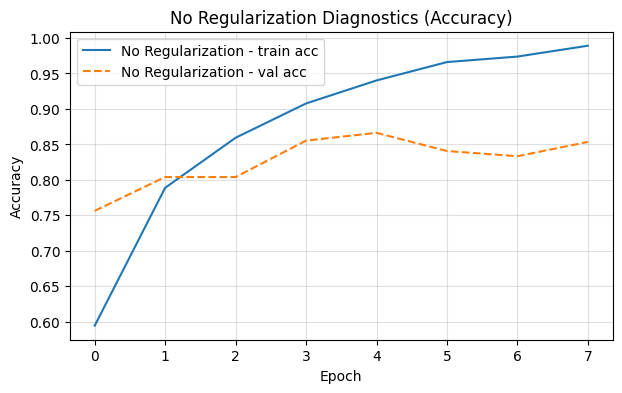

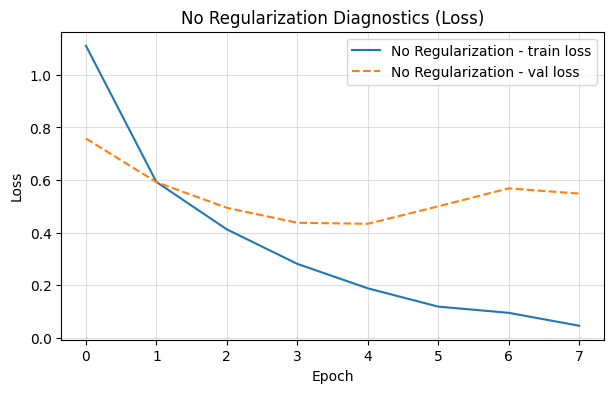

In [18]:
hist, mean_acc_no, test_acc_no = train_kfold_config_L2_or_gc(
    k_folds=K_FOLDS,
    batch_size=best_batch_size,
    lr=best_lr,
    hidden_dim=best_hidden_dim,
    num_layers=NUM_LAYERS,
    bidirectional=BIDIRECTIONAL,
    dropout=DROPOUT,
    num_classes=NUM_CLASSES,
    full_dataset=train_data,    
    test_dataset=test_data,    
    pad_idx=PAD_IDX,
    device=device,
    embedding_layer=embedding_layer,
    max_epochs=MAX_EPOCHS,
    patience=PATIENCE,
    seed=SEED,
    weight_decay=None, # L2
    clip_value=None # GC
)
print(f"\nTrain mean val acc={mean_acc_no:.4f} | TEST acc={test_acc_no:.4f}")
plot_history({"No Regularization": hist}, title="No Regularization Diagnostics")



#### Configuration 2: L2 Regularization (Weight Decay = 1e-4)

[Final Retrain] Epoch 01: train_acc=0.5917, val_acc=0.7527
[Final Retrain] Epoch 02: train_acc=0.7856, val_acc=0.7802
[Final Retrain] Epoch 03: train_acc=0.8534, val_acc=0.8333
[Final Retrain] Epoch 04: train_acc=0.9050, val_acc=0.8407
[Final Retrain] Epoch 05: train_acc=0.9497, val_acc=0.8571
[Final Retrain] Epoch 06: train_acc=0.9605, val_acc=0.8443
[Final Retrain] Epoch 07: train_acc=0.9706, val_acc=0.8315
[Final Retrain] Epoch 08: train_acc=0.9872, val_acc=0.8480
[Final Retrain] Early stopping.

Train mean val acc=0.8235 | TEST acc=0.8940


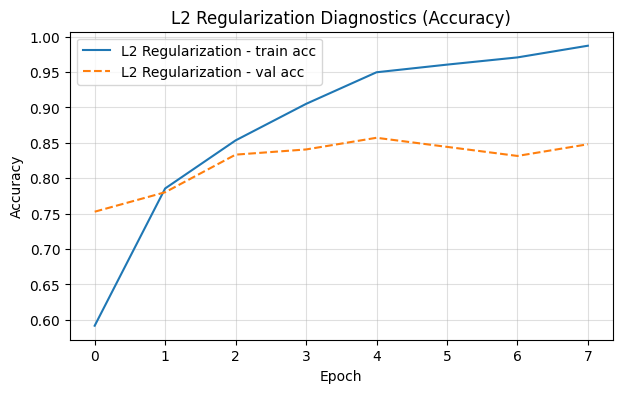

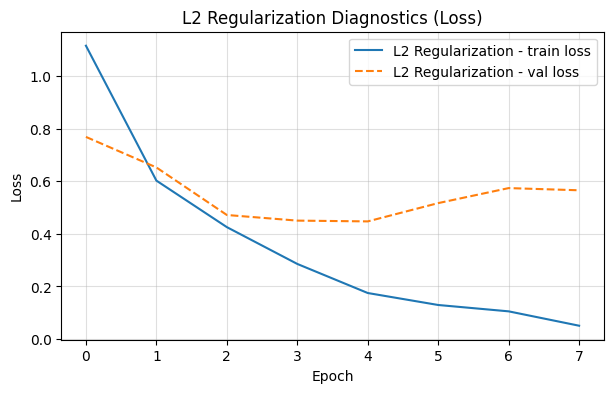

In [19]:
hist, mean_acc_L2, test_acc_L2 = train_kfold_config_L2_or_gc(
    k_folds=K_FOLDS,
    batch_size=best_batch_size,
    lr=best_lr,
    hidden_dim=best_hidden_dim,
    num_layers=NUM_LAYERS,
    bidirectional=BIDIRECTIONAL,
    dropout=DROPOUT,
    num_classes=NUM_CLASSES,
    full_dataset=train_data,    
    test_dataset=test_data,     
    pad_idx=PAD_IDX,
    device=device,
    embedding_layer=embedding_layer,
    max_epochs=MAX_EPOCHS,
    patience=PATIENCE,
    seed=SEED,
    weight_decay=1e-4, # L2
    clip_value=None # GC
)
print(f"\nTrain mean val acc={mean_acc_L2:.4f} | TEST acc={test_acc_L2:.4f}")
plot_history({"L2 Regularization": hist}, title="L2 Regularization Diagnostics")


#### Configuration 3: Gradient Clipping (Clip value = 5.0)

[Final Retrain] Epoch 01: train_acc=0.5946, val_acc=0.7564
[Final Retrain] Epoch 02: train_acc=0.7888, val_acc=0.8040
[Final Retrain] Epoch 03: train_acc=0.8604, val_acc=0.8132
[Final Retrain] Epoch 04: train_acc=0.9060, val_acc=0.8516
[Final Retrain] Epoch 05: train_acc=0.9464, val_acc=0.8462
[Final Retrain] Epoch 06: train_acc=0.9635, val_acc=0.8388
[Final Retrain] Epoch 07: train_acc=0.9747, val_acc=0.8187
[Final Retrain] Early stopping.

Train mean val acc=0.8184 | TEST acc=0.8880


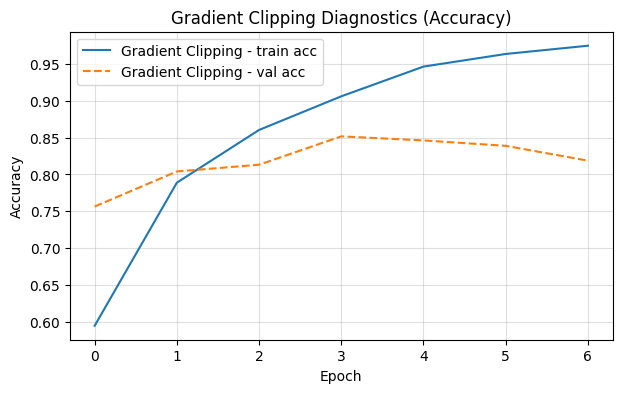

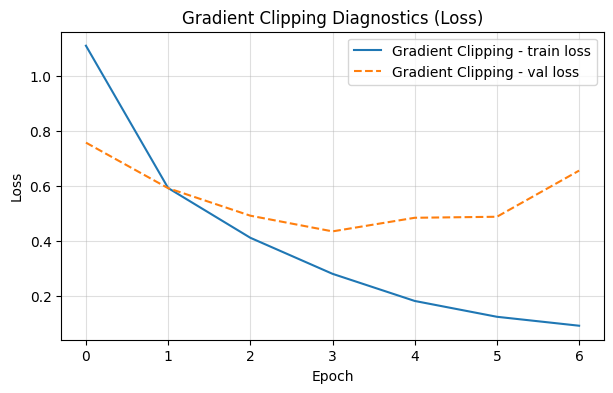

In [20]:
hist, mean_acc_gc, test_acc_gc = train_kfold_config_L2_or_gc(
    k_folds=K_FOLDS,
    batch_size=best_batch_size,
    lr=best_lr,
    hidden_dim=best_hidden_dim,
    num_layers=NUM_LAYERS,
    bidirectional=BIDIRECTIONAL,
    dropout=DROPOUT,
    num_classes=NUM_CLASSES,
    full_dataset=train_data,
    test_dataset=test_data, 
    pad_idx=PAD_IDX,
    device=device,
    embedding_layer=embedding_layer,
    max_epochs=MAX_EPOCHS,
    patience=PATIENCE,
    seed=SEED,
    weight_decay=None, # L2
    clip_value=5.0 # GC
)
print(f"\nTrain mean val acc={mean_acc_gc:.4f} | TEST acc={test_acc_gc:.4f}")
plot_history({"Gradient Clipping": hist}, title="Gradient Clipping Diagnostics")


#### Configuration 4: L2 Regularization (Weight Decay = 1e-4) + Gradient Clipping (Clip value = 5.0)

[Final Retrain] Epoch 01: train_acc=0.5917, val_acc=0.7527
[Final Retrain] Epoch 02: train_acc=0.7860, val_acc=0.7894
[Final Retrain] Epoch 03: train_acc=0.8520, val_acc=0.8168
[Final Retrain] Epoch 04: train_acc=0.9056, val_acc=0.8480
[Final Retrain] Epoch 05: train_acc=0.9462, val_acc=0.8681
[Final Retrain] Epoch 06: train_acc=0.9633, val_acc=0.8388
[Final Retrain] Epoch 07: train_acc=0.9759, val_acc=0.8315
[Final Retrain] Epoch 08: train_acc=0.9859, val_acc=0.8462
[Final Retrain] Early stopping.

Train mean val acc=0.8239 | TEST acc=0.9000


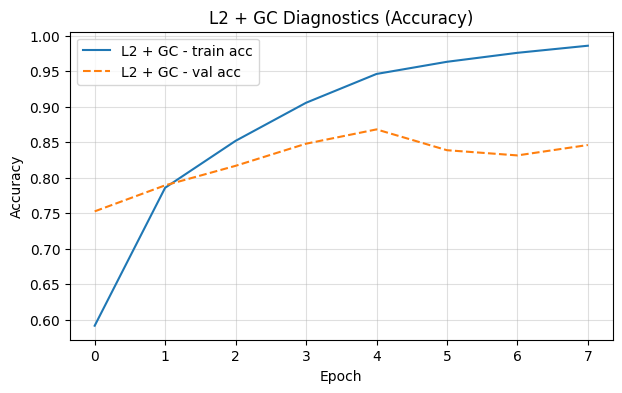

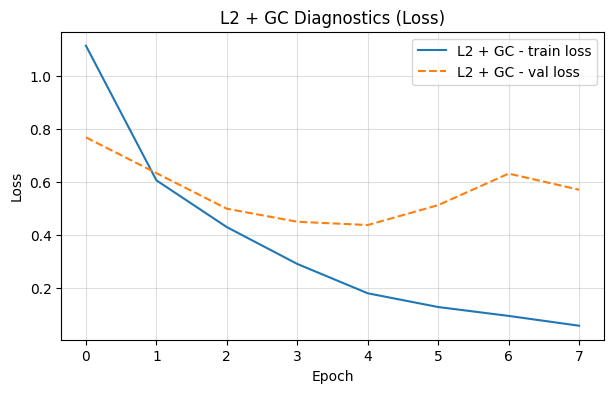

In [21]:
hist, mean_acc_L2_gc, test_acc_L2_gc = train_kfold_config_L2_or_gc(
    k_folds=K_FOLDS,
    batch_size=best_batch_size,
    lr=best_lr,
    hidden_dim=best_hidden_dim,
    num_layers=NUM_LAYERS,
    bidirectional=BIDIRECTIONAL,
    dropout=DROPOUT,
    num_classes=NUM_CLASSES,
    full_dataset=train_data,
    test_dataset=test_data,
    pad_idx=PAD_IDX,
    device=device,
    embedding_layer=embedding_layer,
    max_epochs=MAX_EPOCHS,
    patience=PATIENCE,
    seed=SEED,
    weight_decay=1e-4, # L2
    clip_value=5.0 # GC
)
print(f"\nTrain mean val acc={mean_acc_L2_gc:.4f} | TEST acc={test_acc_L2_gc:.4f}")
plot_history({"L2 + GC": hist}, title="L2 + GC Diagnostics")


In [22]:
acc = [test_acc_no, test_acc_L2, test_acc_gc, test_acc_L2_gc]
name = ["No Reg", "L2 Reg", "GC Reg", "L2+GC Reg"]
clipped_acc = list(zip(name, acc))
sorted_acc = sorted(clipped_acc, key=lambda x: x[1], reverse=True)
print("Final Test Accuracies (sorted):")
for i, a in enumerate(sorted_acc):
    print(f"Rank {i+1}: {a[0]} | {a[1]:.4f}")

Final Test Accuracies (sorted):
Rank 1: No Reg | 0.9000
Rank 2: L2+GC Reg | 0.9000
Rank 3: L2 Reg | 0.8940
Rank 4: GC Reg | 0.8880


#### Overall Logical Conclusion

Regularization in NLP is a technique to prevent models from overfitting by adding a penalty to the loss function or by constraining the model's complexity, which helps improve its ability to generalize to new, unseen data. 

Among the four configurations tested, both the No Regularization and L2 + Gradient Clipping model achieved the highest test accuracy of 0.9000, while L2 and Gradient Clipping alone fell behind slightly. This near-identical performance between the best two settings indicates that the model's capacity and optimization were already well-balanced from the start, with minimal overfitting observed.

Although the L2 + GC variant produced marginally smoother validation curves, its benefit was negligible compared to the unregularized baseline. The No Reg model reached the same test accuracy with fewer constraints, suggesting that additional penalties or clipping did not meaningfully enhance generalization for this dataset.

The outcome implies that the RNN architecture generalizes well without heavy regularization, likely due to its moderate size, early stopping and relatively small training corpus. Therefore, for subsequent experiments moving forward (testing sentence-representation strategies), the No Reg configuration will be adopted as the reference model. It offers a simpler and cleaner baseline, ensuring that any future performance differences can be attributed solely to the architectural choices rather than the side effects of regularization.

### Q2(c) -- best is No Regularization

![image.png](No_Reg_image_1.png)

![image-2.png](No_Reg_image_2.png)

Plot of No Regularization curves (the best model):

- Fast and efficient learning: The training accuracy increases sharply during the first few epochs (from ~0.60 to ~0.95 by epoch 4), indicating that the RNN quickly captures the main relationships between word embeddings and topic labels.

- Saturation and convergence: After epoch 4, the training curve flattens near 1.0 while validation accuracy plateaus around 0.86. This suggest that the model has nearly reached its representational capacity for the dataset.

- Mild overfitting but stable behavior: Validation accuracy slightly fluctuates after epoch 4 and vlaidation loss stops decreasing, showing minor overfitting but no instability or sudden degradation. The training loss continues to decrease smoothly, confirming that the optimization process is steady and gradients remain well-behaved even without regularization.

- Interpretation: The model generalizes well without any explicit regularization, aided by early stopping and a balanced architecture. Additional penalties (L2 or gradient clipping) offered no measureable test-set gain, meaning the unregularized configuration already achieves optimal performance for this task. 

### Q2(d)

In [15]:
best_batch_size = 32
best_lr = 0.001
best_hidden_dim = 96
K_FOLDS = 5
NUM_LAYERS    = 1
BIDIRECTIONAL = True
DROPOUT = 0.3
MAX_EPOCHS    = 50
PATIENCE      = 3
SEED          = 42
K_FOLDS       = 5
NUM_CLASSES   = len(LABEL.vocab)
full_dataset = train_data
test_dataset = test_data
retrain_val_ratio=0.1
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

#### RNN model definition that supports 3 different methods of sentence segmentation. Previous models only support "last"

In [21]:
# Simple RNN classifier (tanh)  — now with pooling (default='last')
class RNNClassifier(nn.Module):
    def __init__(self, embedding_layer, hidden_dim, num_layers, bidirectional, dropout, num_classes, pooling="last"):
        super().__init__()
        self.embedding = embedding_layer
        emb_dim = self.embedding.weight.size(1)

        self.rnn = nn.RNN(
            input_size=emb_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            nonlinearity="tanh",      # simple RNN
            batch_first=True,
            bidirectional=bidirectional,
            dropout=dropout if num_layers > 1 else 0.0
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * (2 if bidirectional else 1), num_classes)

        assert pooling in ["last", "avg", "max"]
        self.pooling = pooling

    def forward(self, text):
        x = self.embedding(text)                     # [B, T, E]
        outputs, hidden = self.rnn(x)                # outputs: [B, T, H*dirs], hidden: [L*D, B, H]

        if self.pooling == "last":
            # IDENTICAL to your original baseline: last hidden state(s)
            if self.rnn.bidirectional:
                rep = torch.cat((hidden[-2], hidden[-1]), dim=1)  # [B, 2H]
            else:
                rep = hidden[-1]                                   # [B, H]

        elif self.pooling == "avg":
            rep = outputs.mean(dim=1)  # [B, H*dirs]

        elif self.pooling == "max":
            rep, _ = torch.max(outputs, dim=1)  # [B, H*dirs]

        return self.fc(self.dropout(rep))


In [19]:
def build_model(embedding_layer, pad_idx, hidden_dim, num_layers, bidirectional, dropout, num_classes, device, pooling="last"):
    # IMPORTANT: keep the SAME embedding init source as baseline:
    emb_layer = nn.Embedding.from_pretrained(
        embedding_layer.weight.data.clone(), freeze=False, padding_idx=pad_idx
    )
    model = RNNClassifier(
        embedding_layer=emb_layer,
        hidden_dim=hidden_dim,
        num_layers=num_layers,
        bidirectional=bidirectional,
        dropout=dropout,
        num_classes=num_classes,
        pooling=pooling               # <- new
    ).to(device)
    return model


In [26]:
def choose_pooling(batch_size, lr, hidden_dim, *,
                   num_layers, bidirectional, dropout, num_classes,
                   full_dataset, pad_idx, device, embedding_layer,
                   test_dataset, # pass test_data here
                   max_epochs=20, patience=3, seed=42,
                   weight_decay=None, clip_value=None, # Off L2 + GC knobs
                   pooling):   

    def _set_seed(s):
        random.seed(s); np.random.seed(s)
        torch.manual_seed(s); torch.cuda.manual_seed_all(s)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    @torch.no_grad()
    def _evaluate(iterator, model, criterion):
        model.eval()
        tot_loss = tot_correct = tot_count = 0
        for batch in iterator:
            text, labels = batch.text, batch.label
            logits = model(text)
            loss = criterion(logits, labels)
            tot_loss   += loss.item() * labels.size(0)
            tot_correct += (logits.argmax(1) == labels).sum().item()
            tot_count  += labels.size(0)
        return tot_loss / max(tot_count,1), tot_correct / max(tot_count,1)

    def _train_epoch(it, model, criterion, optimizer, clip_value):
        model.train()
        tot_loss = tot_correct = tot_count = 0
        for batch in it:
            text, labels = batch.text, batch.label
            logits = model(text)
            loss = criterion(logits, labels)
            optimizer.zero_grad()
            loss.backward()
            if clip_value is not None:  # gradient clipping here
                torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
            optimizer.step()
            tot_loss   += loss.item() * labels.size(0)
            tot_correct += (logits.argmax(1) == labels).sum().item()
            tot_count  += labels.size(0)
        return tot_loss / max(tot_count,1), tot_correct / max(tot_count,1)

    _set_seed(seed)

    # Final retrain on FULL training set
    _set_seed(seed)
    n = len(full_dataset.examples)
    idx = np.arange(n)
    rng = np.random.default_rng(seed)
    rng.shuffle(idx)
    cut = int((1.0 - retrain_val_ratio) * n)
    tr_idx, va_idx = idx[:cut], idx[cut:]
    
    full_tr_ds = data.Dataset([full_dataset.examples[i] for i in tr_idx], fields=full_dataset.fields)
    full_va_ds = data.Dataset([full_dataset.examples[i] for i in va_idx], fields=full_dataset.fields)

    full_tr_iter, full_va_iter = build_iters(batch_size, full_tr_ds, full_va_ds, device)

    final_model = build_model(embedding_layer, pad_idx, hidden_dim, num_layers,
                              bidirectional, dropout, num_classes, device, pooling=pooling)
    criterion = nn.CrossEntropyLoss()
    if weight_decay is None:
        optimizer = torch.optim.Adam(final_model.parameters(), lr=lr)
    else:
        optimizer = torch.optim.Adam(final_model.parameters(), lr=lr, weight_decay=weight_decay)

    best_state, best_val_acc, no_improve = None, -1.0, 0

    hist = {"train_acc": [], "val_acc": [], "train_loss": [], "val_loss": []}
    for epoch in range(1, max_epochs + 1):
        tr_loss, tr_acc = _train_epoch(full_tr_iter, final_model, criterion, optimizer, clip_value)
        va_loss, va_acc = _evaluate(full_va_iter, final_model, criterion)
        print(f"[Final Retrain] Epoch {epoch:02d}: train_acc={tr_acc:.4f}, val_acc={va_acc:.4f}")
        hist["train_loss"].append(tr_loss); hist["train_acc"].append(tr_acc)
        hist["val_loss"].append(va_loss);   hist["val_acc"].append(va_acc)

        if va_acc > best_val_acc:
            best_val_acc, no_improve = va_acc, 0
            best_state = copy.deepcopy(final_model.state_dict())
        else:
            no_improve += 1
            if no_improve >= patience:
                print("[Final Retrain] Early stopping.")
                break

    if best_state is not None:
        final_model.load_state_dict(best_state)

    mean_acc = float(np.mean(hist["val_acc"]))

    # Evaluate once on TEST set
    test_iter = data.BucketIterator(
        test_dataset, batch_size=batch_size,
        sort_key=lambda x: len(x.text), sort_within_batch=True,
        device=device, train=False, shuffle=False
    )
    test_loss, test_acc = _evaluate(test_iter, final_model, criterion)

    return hist, mean_acc, float(test_acc)


In [27]:
# Plot function
def plot_history(histories, title="Learning Curves"):
    plt.figure(figsize=(7,4))
    for name, h in histories.items():
        plt.plot(h["train_acc"], label=f"{name} - train acc")
        plt.plot(h["val_acc"],   label=f"{name} - val acc", linestyle="--")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title(title + " (Accuracy)")
    plt.grid(True, alpha=0.4); plt.legend(); plt.show()

    plt.figure(figsize=(7,4))
    for name, h in histories.items():
        plt.plot(h["train_loss"], label=f"{name} - train loss")
        plt.plot(h["val_loss"],   label=f"{name} - val loss", linestyle="--")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title(title + " (Loss)")
    plt.grid(True, alpha=0.4); plt.legend(); plt.show()


#### Using "Last" Hidden State

[Final Retrain] Epoch 01: train_acc=0.5946, val_acc=0.7564
[Final Retrain] Epoch 02: train_acc=0.7888, val_acc=0.8040
[Final Retrain] Epoch 03: train_acc=0.8594, val_acc=0.8040
[Final Retrain] Epoch 04: train_acc=0.9077, val_acc=0.8553
[Final Retrain] Epoch 05: train_acc=0.9401, val_acc=0.8663
[Final Retrain] Epoch 06: train_acc=0.9660, val_acc=0.8407
[Final Retrain] Epoch 07: train_acc=0.9737, val_acc=0.8333
[Final Retrain] Epoch 08: train_acc=0.9890, val_acc=0.8535
[Final Retrain] Early stopping.

Train mean val acc=0.8267 | TEST acc=0.9000


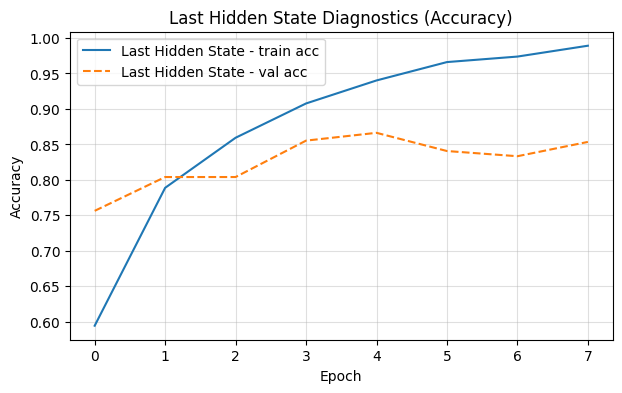

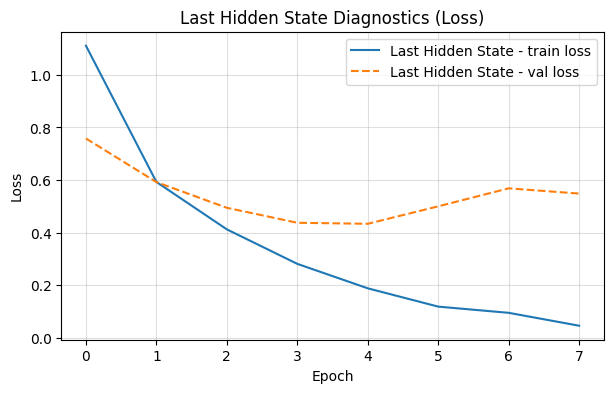

In [28]:
hist, mean_acc_last, test_acc_last = choose_pooling(
    batch_size=best_batch_size,
    lr=best_lr,
    hidden_dim=best_hidden_dim,
    num_layers=NUM_LAYERS,
    bidirectional=BIDIRECTIONAL,
    dropout=DROPOUT,
    num_classes=NUM_CLASSES,
    full_dataset=train_data,    
    test_dataset=test_data,    
    pad_idx=PAD_IDX,
    device=device,
    embedding_layer=embedding_layer,
    max_epochs=MAX_EPOCHS,
    patience=PATIENCE,
    seed=SEED,
    weight_decay=None, # no L2
    clip_value=None, # no GC
    pooling="last"
)
print(f"\nTrain mean val acc={mean_acc_last:.4f} | TEST acc={test_acc_last:.4f}")
plot_history({"Last Hidden State": hist}, title="Last Hidden State Diagnostics")

#### Using "Average" Pooling

[Final Retrain] Epoch 01: train_acc=0.3233, val_acc=0.2546
[Final Retrain] Epoch 02: train_acc=0.4368, val_acc=0.6264
[Final Retrain] Epoch 03: train_acc=0.5903, val_acc=0.5165
[Final Retrain] Epoch 04: train_acc=0.6109, val_acc=0.6447
[Final Retrain] Epoch 05: train_acc=0.6971, val_acc=0.6886
[Final Retrain] Epoch 06: train_acc=0.7744, val_acc=0.6996
[Final Retrain] Epoch 07: train_acc=0.8031, val_acc=0.7326
[Final Retrain] Epoch 08: train_acc=0.8669, val_acc=0.7454
[Final Retrain] Epoch 09: train_acc=0.9056, val_acc=0.7527
[Final Retrain] Epoch 10: train_acc=0.9278, val_acc=0.7216
[Final Retrain] Epoch 11: train_acc=0.9291, val_acc=0.7363
[Final Retrain] Epoch 12: train_acc=0.8801, val_acc=0.6960
[Final Retrain] Early stopping.

Train mean val acc=0.6513 | TEST acc=0.7940


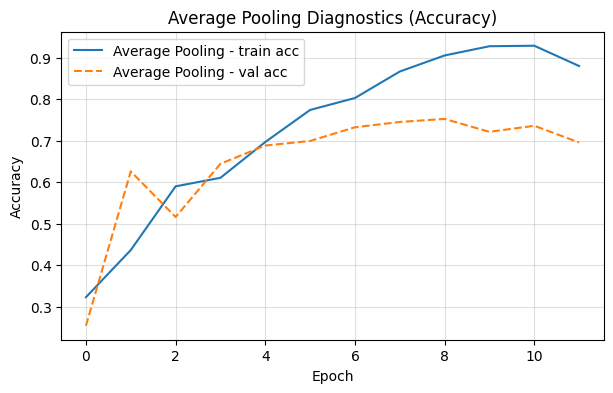

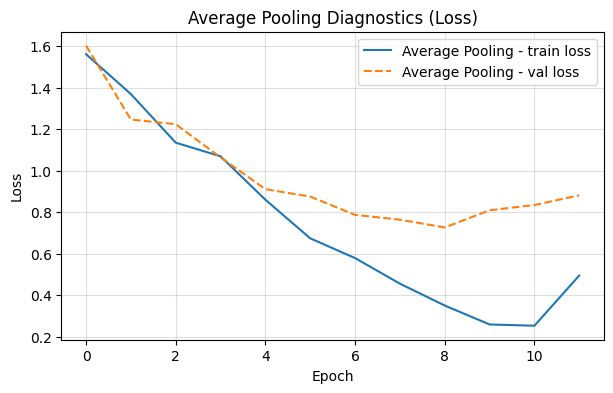

In [29]:
hist, mean_acc_avg, test_acc_avg = choose_pooling(
    batch_size=best_batch_size,
    lr=best_lr,
    hidden_dim=best_hidden_dim,
    num_layers=NUM_LAYERS,
    bidirectional=BIDIRECTIONAL,
    dropout=DROPOUT,
    num_classes=NUM_CLASSES,
    full_dataset=train_data,    
    test_dataset=test_data,    
    pad_idx=PAD_IDX,
    device=device,
    embedding_layer=embedding_layer,
    max_epochs=MAX_EPOCHS,
    patience=PATIENCE,
    seed=SEED,
    weight_decay=None, # no L2
    clip_value=None, # no GC
    pooling="avg"
)
print(f"\nTrain mean val acc={mean_acc_avg:.4f} | TEST acc={test_acc_avg:.4f}")
plot_history({"Average Pooling": hist}, title="Average Pooling Diagnostics")

#### Using "Maximum" Pooling

[Final Retrain] Epoch 01: train_acc=0.4845, val_acc=0.7308
[Final Retrain] Epoch 02: train_acc=0.7625, val_acc=0.7930
[Final Retrain] Epoch 03: train_acc=0.8530, val_acc=0.8462
[Final Retrain] Epoch 04: train_acc=0.9044, val_acc=0.8590
[Final Retrain] Epoch 05: train_acc=0.9437, val_acc=0.8901
[Final Retrain] Epoch 06: train_acc=0.9600, val_acc=0.8864
[Final Retrain] Epoch 07: train_acc=0.9725, val_acc=0.8828
[Final Retrain] Epoch 08: train_acc=0.9874, val_acc=0.8828
[Final Retrain] Early stopping.

Train mean val acc=0.8464 | TEST acc=0.8940


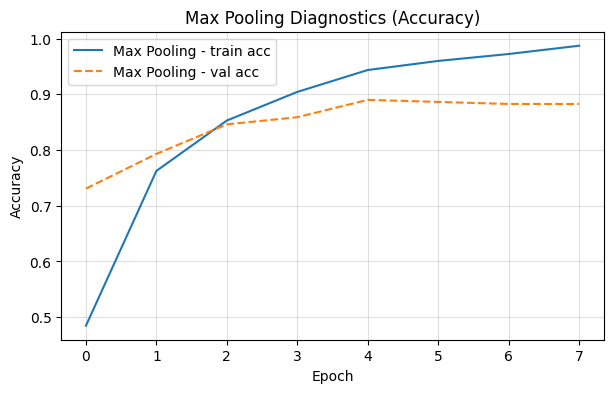

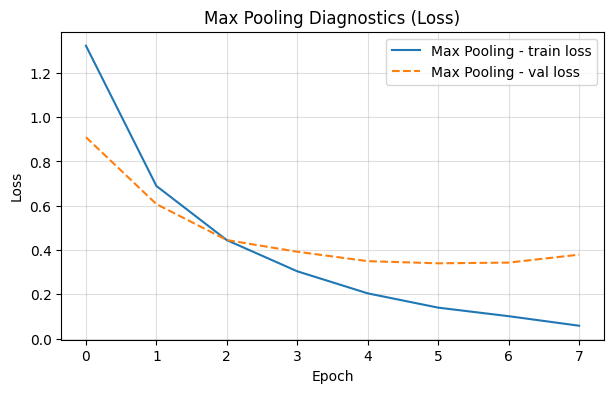

In [30]:
hist, mean_acc_max, test_acc_max = choose_pooling(
    batch_size=best_batch_size,
    lr=best_lr,
    hidden_dim=best_hidden_dim,
    num_layers=NUM_LAYERS,
    bidirectional=BIDIRECTIONAL,
    dropout=DROPOUT,
    num_classes=NUM_CLASSES,
    full_dataset=train_data,    
    test_dataset=test_data,    
    pad_idx=PAD_IDX,
    device=device,
    embedding_layer=embedding_layer,
    max_epochs=MAX_EPOCHS,
    patience=PATIENCE,
    seed=SEED,
    weight_decay=None, # no L2
    clip_value=None, # no GC
    pooling="max"
)
print(f"\nTrain mean val acc={mean_acc_max:.4f} | TEST acc={test_acc_max:.4f}")
plot_history({"Max Pooling": hist}, title="Max Pooling Diagnostics")

In [31]:
print("Summary of Test Accuracies:")
print(f"Last Hidden State : {test_acc_last:.4f}")
print(f"Average Pooling   : {test_acc_avg:.4f}")
print(f"Max Pooling       : {test_acc_max:.4f}")


Summary of Test Accuracies:
Last Hidden State : 0.9000
Average Pooling   : 0.7940
Max Pooling       : 0.8940


## Explanation

1. **Last Hidden State** representation takes the final output of the RNN.

    It is assumed that by the end of processing the sequence, the model has encoded all relevant context into this final state, preserving sequential information, making it suitable for short or moderately long sentences where the model can retain dependencies across all tokens.

2. **Average Pooling** computes the mean of all hidden states across time steps.

    It produces a smooth, stable representation by averaging every token’s contribution equally.
    However, it dilutes key features, especially if only a few words (key features) are informative for classification because it assumes that every word contributes equally to meaning, which is normally unrealistic for natural language.

3. **Max Pooling** takes the maximum value across all steps for each feature dimension. 

    It captures the strongest signal/word that may appear in any sentence position.
    While this helps detect important feature words regardless of their position, it ignores word order and may lose contextual information.

The last hidden state achieved the highest test accuracy (0.9000).
This aligns with expectations because the TREC dataset contains short questions (mostly 5–15 tokens long as shown in the histogram).
In such sequence lengths, the RNN can effectively retain all contextual information until the final step.
The last hidden state thus carries a reasonable amount of summary of the question for decent accuracy of classification tasks where sequence order (e.g., “what kind of …”, “what is …”) is meaningful.
For longer texts, however, this method could struggle due to vanishing gradients, which cause the model to diminish early information.

Average pooling performed the worst (0.7940) because averaging tends to blur distinctive features.
Not all parts of a sentence contribute equally to determining its question type, but this method smooths out the representation, therefore reducing the model’s ability to focus on informative tokens.

Max pooling (0.8940) captured strong keyword-related signals (“who”, “where”, “when”), making it nearly as good as the last hidden state.
However, since it ignores sequential structure, it slightly underperforms in a task where word order and syntactic context also matter.

#### Visualization of sentence length distribution across the entire dataset

Total samples: 5452
Min length: 3
Max length: 37
Average length: 10.43


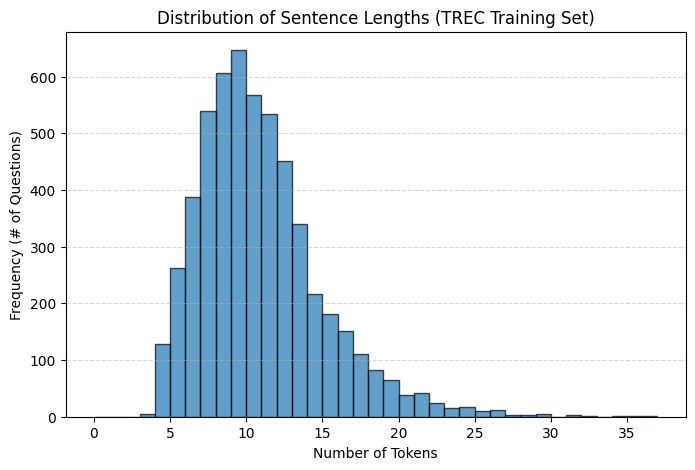

In [10]:
import matplotlib.pyplot as plt

# Compute sentence lengths (number of tokens per example)
sentence_lengths = [len(example.text) for example in train_data]

# Basic stats
print(f"Total samples: {len(sentence_lengths)}")
print(f"Min length: {min(sentence_lengths)}")
print(f"Max length: {max(sentence_lengths)}")
print(f"Average length: {sum(sentence_lengths)/len(sentence_lengths):.2f}")

# Plot histogram of sentence lengths
plt.figure(figsize=(8,5))
plt.hist(sentence_lengths, bins=range(0, max(sentence_lengths)+1), edgecolor='black', alpha=0.7)
plt.title("Distribution of Sentence Lengths (TREC Training Set)")
plt.xlabel("Number of Tokens")
plt.ylabel("Frequency (# of Questions)")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


### Q2(e)

#### Topic-wise accuracy reporting with final configuration


In [23]:
def choose_pooling_with_topicwise(batch_size, lr, hidden_dim, *,
                                  num_layers, bidirectional, dropout, num_classes,
                                  full_dataset, pad_idx, device, embedding_layer,
                                  test_dataset, vocab, label_field,  # add vocab + LABEL field here
                                  max_epochs=20, patience=3, seed=42,
                                  weight_decay=None, clip_value=None, pooling="last"):

    # === Helper functions reused ===
    def _set_seed(s):
        random.seed(s); np.random.seed(s)
        torch.manual_seed(s); torch.cuda.manual_seed_all(s)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    @torch.no_grad()
    def _evaluate(iterator, model, criterion):
        model.eval()
        tot_loss = tot_correct = tot_count = 0
        all_preds, all_labels = [], []
        for batch in iterator:
            text, labels = batch.text, batch.label
            logits = model(text)
            loss = criterion(logits, labels)
            tot_loss   += loss.item() * labels.size(0)
            tot_correct += (logits.argmax(1) == labels).sum().item()
            tot_count  += labels.size(0)
            all_preds.extend(logits.argmax(1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
        return tot_loss / max(tot_count,1), tot_correct / max(tot_count,1), np.array(all_preds), np.array(all_labels)

    def _train_epoch(it, model, criterion, optimizer, clip_value):
        model.train()
        tot_loss = tot_correct = tot_count = 0
        for batch in it:
            text, labels = batch.text, batch.label
            logits = model(text)
            loss = criterion(logits, labels)
            optimizer.zero_grad()
            loss.backward()
            if clip_value is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), clip_value)
            optimizer.step()
            tot_loss   += loss.item() * labels.size(0)
            tot_correct += (logits.argmax(1) == labels).sum().item()
            tot_count  += labels.size(0)
        return tot_loss / max(tot_count,1), tot_correct / max(tot_count,1)

    # === Same training setup as before ===
    _set_seed(seed)
    n = len(full_dataset.examples)
    idx = np.arange(n)
    rng = np.random.default_rng(seed)
    rng.shuffle(idx)
    cut = int((1.0 - retrain_val_ratio) * n)
    tr_idx, va_idx = idx[:cut], idx[cut:]
    full_tr_ds = data.Dataset([full_dataset.examples[i] for i in tr_idx], fields=full_dataset.fields)
    full_va_ds = data.Dataset([full_dataset.examples[i] for i in va_idx], fields=full_dataset.fields)

    full_tr_iter, full_va_iter = build_iters(batch_size, full_tr_ds, full_va_ds, device)

    final_model = build_model(embedding_layer, pad_idx, hidden_dim, num_layers,
                              bidirectional, dropout, num_classes, device, pooling=pooling)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(final_model.parameters(), lr=lr, weight_decay=(weight_decay or 0.0))

    best_state, best_val_acc, no_improve = None, -1.0, 0
    hist = {"train_acc": [], "val_acc": [], "train_loss": [], "val_loss": []}

    for epoch in range(1, max_epochs + 1):
        tr_loss, tr_acc = _train_epoch(full_tr_iter, final_model, criterion, optimizer, clip_value)
        va_loss, va_acc, _, _ = _evaluate(full_va_iter, final_model, criterion)
        print(f"[Final Retrain] Epoch {epoch:02d}: train_acc={tr_acc:.4f}, val_acc={va_acc:.4f}")
        hist["train_loss"].append(tr_loss); hist["train_acc"].append(tr_acc)
        hist["val_loss"].append(va_loss);   hist["val_acc"].append(va_acc)

        if va_acc > best_val_acc:
            best_val_acc, no_improve = va_acc, 0
            best_state = copy.deepcopy(final_model.state_dict())
        else:
            no_improve += 1
            if no_improve >= patience:
                print("[Final Retrain] Early stopping.")
                break

    if best_state is not None:
        final_model.load_state_dict(best_state)

    # === Evaluate once on TEST set ===
    test_iter = data.BucketIterator(
        test_dataset, batch_size=batch_size,
        sort_key=lambda x: len(x.text), sort_within_batch=True,
        device=device, train=False, shuffle=False
    )
    test_loss, test_acc, preds, labels = _evaluate(test_iter, final_model, criterion)

    # === Compute topic-wise accuracies ===
    topics = label_field.vocab.itos
    topic_correct = {t: 0 for t in topics}
    topic_total = {t: 0 for t in topics}

    for pred, true in zip(preds, labels):
        topic_total[topics[true]] += 1
        if pred == true:
            topic_correct[topics[true]] += 1

    topic_acc = {t: topic_correct[t] / topic_total[t] if topic_total[t] > 0 else 0.0 for t in topics}

    sorted_topics = sorted(topic_acc.items(), key=lambda x: x[1], reverse=True)

    print("\n📊 Topic-wise Accuracy on Test Set (sorted by accuracy):")
    for t, acc in sorted_topics:
        correct = topic_correct[t]
        total = topic_total[t]
        print(f"{t:>10s}: {acc:.4f}  ({correct}/{total})")

    return hist, float(np.mean(hist["val_acc"])), float(test_acc), topic_acc


In [24]:
hist, mean_acc, test_acc, topic_acc = choose_pooling_with_topicwise(
    batch_size=best_batch_size,
    lr=best_lr,
    hidden_dim=best_hidden_dim,
    num_layers=NUM_LAYERS,
    bidirectional=BIDIRECTIONAL,
    dropout=DROPOUT,
    num_classes=NUM_CLASSES,
    full_dataset=train_data,    
    test_dataset=test_data,    
    pad_idx=PAD_IDX,
    device=device,
    embedding_layer=embedding_layer,
    vocab=TEXT.vocab,
    label_field=LABEL,   # required for topic names
    max_epochs=MAX_EPOCHS,
    patience=PATIENCE,
    seed=SEED,
    weight_decay=None,  # no L2
    clip_value=None,    # no GC
    pooling="last"      # use best pooling from Q2(d)
)

[Final Retrain] Epoch 01: train_acc=0.5946, val_acc=0.7564
[Final Retrain] Epoch 02: train_acc=0.7888, val_acc=0.8040
[Final Retrain] Epoch 03: train_acc=0.8594, val_acc=0.8040
[Final Retrain] Epoch 04: train_acc=0.9077, val_acc=0.8553
[Final Retrain] Epoch 05: train_acc=0.9401, val_acc=0.8663
[Final Retrain] Epoch 06: train_acc=0.9660, val_acc=0.8407
[Final Retrain] Epoch 07: train_acc=0.9737, val_acc=0.8333
[Final Retrain] Epoch 08: train_acc=0.9890, val_acc=0.8535
[Final Retrain] Early stopping.

📊 Topic-wise Accuracy on Test Set (sorted by accuracy):
      DESC: 0.9710  (134/138)
       LOC: 0.9630  (78/81)
       NUM: 0.9204  (104/113)
       HUM: 0.8923  (58/65)
      ENTY: 0.7447  (70/94)
      ABBR: 0.6667  (6/9)


## Analysis on topic-wise accuracy

DESC (Description) - 0.9710:
Achieved the highest accuracy, likely because descriptive questions contains explicit keywords like ("what is", "explain", "define") that makes them easily identifiable. 

LOC (Location) - 0.9630:
Performs very well, as location-based questions often include strong geographic cues such as "where", "city", or "country"

NUM (Numeric) - 0.9204:
Has also attain a similarly high accuracy, since numerical questions typically include numbers or quantitative terms like "how many", "what year"

HUM (Human) - 0.8923: 
Performs decently as human-related questions often start with "who", but can sometimes be confused with entities or organizations (e.g., "Who founded Apple?" vs "What company founded Apple?").

ENTY (Entity) - 0.7447:
Lower accuracy, likely due to the broad and diverse nature of entity types (objects, animals, products, etc.) making them harder for the model to distinguish from other classes.

ABBR (Abbreviation) - 0.6667:
Showed the weakest performance, possibly due to its small sample size in the dataset (only 9 in test data). This may result in lack of training to generalize abbreviation-related patterns.

Overall, the model performs best on categories with clear linguistic markers or distinct question patterns (DESC, LOC, NUM). In contrast, categories with semantic overlap or limited samples like (ENTY, ABBR) suffer reduced performance. This suggests that while our RNN model captures sequential dependencies effectively, it could benefit from data augmentation for minority classes or attention mechanisms like using transformers to better handle semantically subtle categories.

# Additional visual

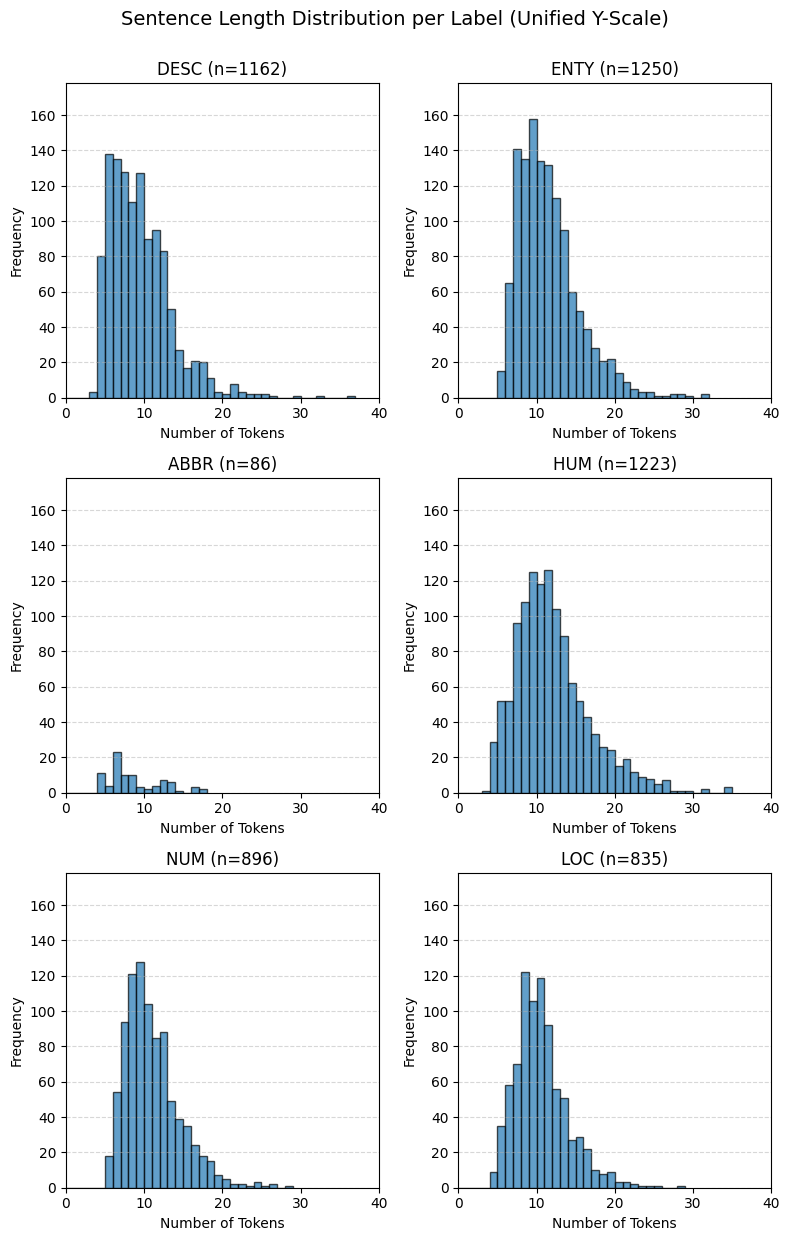

In [11]:
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np

# Compute sentence lengths grouped by label
label_lengths = defaultdict(list)
for example in train_data:
    label_lengths[example.label].append(len(example.text))

# Compute global max frequency (for unified y-scale)
max_count = 0
for lengths in label_lengths.values():
    counts, _ = np.histogram(lengths, bins=range(0, max(lengths)+1))
    max_count = max(max_count, counts.max())

# Plot 6 histograms with unified y-scale
plt.figure(figsize=(8, 12))
for i, (label, lengths) in enumerate(label_lengths.items(), 1):
    plt.subplot(3, 2, i)
    plt.hist(lengths, bins=range(0, max(lengths)+1), edgecolor='black', alpha=0.7)
    plt.title(f"{label.upper()} (n={len(lengths)})")
    plt.xlabel("Number of Tokens")
    plt.ylabel("Frequency")
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.xlim(0, 40)
    plt.ylim(0, max_count + 20)  # unified y-scale

plt.tight_layout()
plt.suptitle("Sentence Length Distribution per Label (Unified Y-Scale)", fontsize=14, y=1.03)
plt.show()


In [12]:
# Compute summary stats for each label
stats = []
for label, lengths in label_lengths.items():
    arr = np.array(lengths)
    stats.append({
        "Label": label.upper(),
        "Count": len(arr),
        "Mean Length": np.mean(arr),
        "Median Length": np.median(arr),
        "Std Dev": np.std(arr),
        "Min": np.min(arr),
        "Max": np.max(arr)
    })

df_stats = pd.DataFrame(stats).sort_values("Mean Length", ascending=False)
display(df_stats)

,Label,Count,Mean Length,Median Length,Std Dev,Min,Max
3,HUM,1223,11.497956,11.0,4.739816,3,35
1,ENTY,1250,11.024800,10.0,3.887645,5,32
4,NUM,896,10.503348,10.0,3.516541,5,29
5,LOC,835,10.100599,10.0,3.408259,4,29
0,DESC,1162,8.995697,8.0,3.959235,3,37
2,ABBR,86,8.162791,7.0,3.460274,4,18


## Additional explanation

Based on the statistics above, we would like to further expand on why HUM labelled sentences perform slightly worse compared to other longer or similarly long categories (>0.92), under our current configurations:

1) Higher Mean Sentence Length:
    - Vanilla RNN's information receives earlier tokens through multiple recurrent steps. And as sequence length increases, the Gradients Backpropagating through time (BPTT) can start to diminish if the weight matrix is small in value, essentially making the model "forget" earlier words when updating weights.
2) "Last" Hidden State Pooling:
    - The most optimal configuration we obtained was to use Last Hidden State Pooling, which meant the model's prediction entirely depends on the final hidden state, which may have weakened information from the start of the sequence due to the vanishing gradient problem. This meant that the crucial indicating words for HUM sentences like "Who", "Which" that usually occurs at the start of the sentences may have diminished signals towards the end.
3) Highest Standard Deviation:
    - A high standard deviation means HUM sentences face more variable sentence structures, making it harder for the model to learn consistent temporal dependencies.